In [4]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.stats import multivariate_normal
from numba import njit
import h5py as h5
from pathlib import Path

import astropy.units as u
import lowda

from joblib import Parallel, delayed

In [2]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'
zoombase = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/TNG/runs/gr187-new/output/'

In [5]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = lowda.get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(lowda.get_time(header.Time))
    meta['time_lookback'].append(t0 - lowda.get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [6]:
# load all stellar masses for TNG galaxy
subID = 523889
tree = il.sublink.loadTree(TNGbase, 99, subID, onlyMPB=True)

TNGhist = {}
TNGhist['SnapNum'] = []
TNGhist['ScaleFactor'] = []
TNGhist['Time'] = []
TNGhist['TimeLookback'] = []
TNGhist['StellarMass'] = []
TNGhist['GroupMass'] = []

for i in range(len(tree['SnapNum'])):
    snapnum = tree['SnapNum'][i]
    TNGhist['SnapNum'].append(snapnum)
    TNGhist['ScaleFactor'].append(meta['scale_factor'][snapnum])
    TNGhist['Time'].append(meta['time'][snapnum])
    TNGhist['TimeLookback'].append(meta['time_lookback'][snapnum])
    TNGhist['StellarMass'].append(tree['SubhaloMassInRadType'][i][4])
    TNGhist['GroupMass'].append(tree['GroupMass'][i])

for k in TNGhist.keys():
    TNGhist[k] = np.array(TNGhist[k])

In [15]:
zoomhist = {}
zoomhist['SnapNum'] = []
zoomhist['ScaleFactor'] = []
zoomhist['Time'] = []
zoomhist['TimeLookback'] = []
zoomhist['StellarMass'] = []
zoomhist['GroupMass'] = []

snapnum = 0
t0 = lowda.get_time(1.)

while True:
    snapnum_str = str(snapnum).zfill(3)
    print(snapnum_str, end='\r')
    fname = zoombase + 'groups_' + snapnum_str + '/fof_subhalo_tab_' + snapnum_str + '.0.hdf5'
    fpath = Path(fname)
    if not fpath.exists():
        break
    
    with h5.File(fname, mode='r') as sub:
        ScaleFactor = sub['Header'].attrs['Time']
        Time = lowda.get_time(ScaleFactor)
        TimeLookback = t0 - Time
    
        zoomhist['SnapNum'].append(snapnum)
        zoomhist['ScaleFactor'].append(ScaleFactor)
        zoomhist['Time'].append(Time)
        zoomhist['TimeLookback'].append(TimeLookback)
    
        if 'SubhaloMassInRadType' in sub['Subhalo'].keys():
            zoomhist['StellarMass'].append(sub['Subhalo']['SubhaloMassInRadType'][0][4])
        else:
            zoomhist['StellarMass'].append(0)
        
        if 'GroupMass' in sub['Group'].keys():
            zoomhist['GroupMass'].append(sub['Group']['GroupMass'][0])
        else:
            zoomhist['GroupMass'].append(0)
    
    snapnum += 1

for k in zoomhist.keys():
    zoomhist[k] = np.array(zoomhist[k])
    

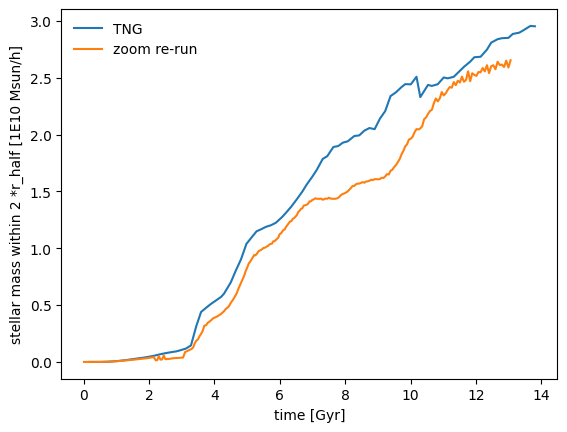

In [16]:
plt.plot(TNGhist['Time'], TNGhist['StellarMass'], label='TNG')
plt.plot(zoomhist['Time'], zoomhist['StellarMass'], label='zoom re-run')
plt.xlabel('time [Gyr]')
plt.ylabel('stellar mass within 2 *r_half [1E10 Msun/h]')
# plt.yscale('log')
plt.legend(frameon=False)

/tmp/ipykernel_2827776/3456314626.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(zoomhist['Time'], np.log10(zoomhist['GroupMass']), label='zoom re-run')


(0.0, 2.232726740837097)

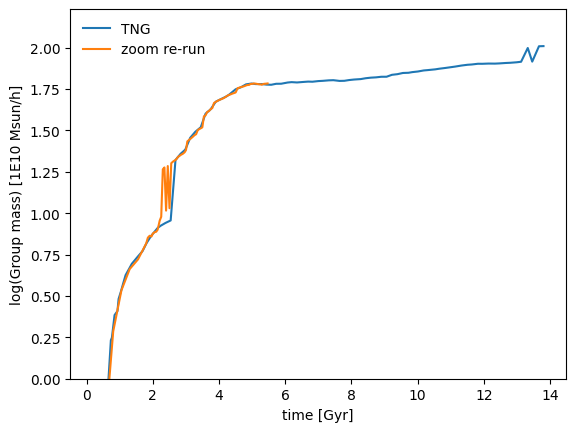

In [9]:
plt.plot(TNGhist['Time'], np.log10(TNGhist['GroupMass']), label='TNG')
plt.plot(zoomhist['Time'], np.log10(zoomhist['GroupMass']), label='zoom re-run')
plt.xlabel('time [Gyr]')
plt.ylabel('log(Group mass) [1E10 Msun/h]')
plt.legend(frameon=False)
plt.ylim(0, None)

In [36]:
snapnum = 277
snapnum_str = str(snapnum).zfill(3)
fname = zoombase + 'groups_' + snapnum_str + '/fof_subhalo_tab_' + snapnum_str + '.0.hdf5'
sub = h5.File(fname, mode='r')

In [59]:
for k in sub['Group'].keys():
    print(k)

GroupBHMass
GroupBHMdot
GroupCM
GroupFirstSub
GroupGasMetalFractions
GroupGasMetallicity
GroupLen
GroupLenType
GroupMass
GroupMassType
GroupNsubs
GroupPos
GroupSFR
GroupStarMetalFractions
GroupStarMetallicity
GroupVel
GroupWindMass
Group_M_Crit200
Group_M_Crit500
Group_M_Mean200
Group_M_TopHat200
Group_R_Crit200
Group_R_Crit500
Group_R_Mean200
Group_R_TopHat200


In [45]:
snapnum = 150
snapnum_str = str(snapnum).zfill(3)
fname = zoombase + 'groups_' + snapnum_str + '/fof_subhalo_tab_' + snapnum_str + '.0.hdf5'
sub = h5.File(fname, mode='r')

snz = lowda.load_zoom_group(zoombase, snapnum)

In [46]:
rhalf = sub['Subhalo']['SubhaloHalfmassRadType'][0][4]
center = sub['Subhalo']['SubhaloPos'][0]
r = np.linalg.norm(snz['PartType0']['Coordinates'] - center, axis=1)
key = r < 2 * rhalf

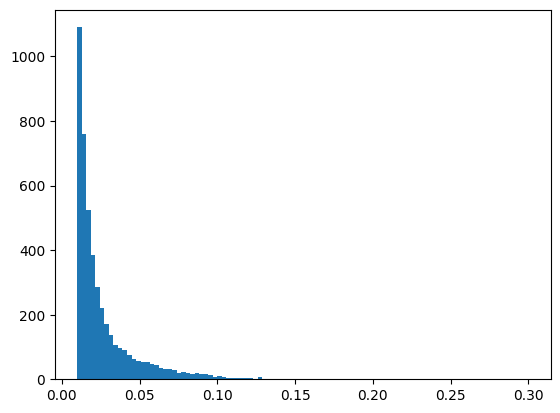

In [49]:
physdens = snz['PartType0']['Density'][key] / sub['Header'].attrs['Time']**3
plt.hist(snz['PartType0']['Density'][key], bins=100, range=(0.01, 0.3));

In [54]:
sub['Group']['GroupMass'][0]

52.87231

In [55]:
sub_all = arepo.Subfind(zoombase, snapnum, combineFiles=True)

In [58]:
sub_all.GroupMass[:10]

array([52.87231   ,  8.022994  ,  2.4746447 ,  1.752679  ,  1.5171502 ,
        1.2944692 ,  1.08623   ,  0.77262056,  0.8005268 ,  0.751893  ],
      dtype=float32)

In [69]:
dlna = 0.001184577701
a = 0.232909664
da = a * dlna
lowda.get_time(a+da) - lowda.get_time(a)

0.0034111610569429462

In [74]:
lowda.get_time(0.3414985059)

3.4059315570425897